### Approach 1: Deep Neural Net 

#### Import necessary dependencies

In [1]:
import pandas as pd
import numpy as np

### NOTE: We'll use Keras as our hook into TensorFlow to build a CNN layer by layer 
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
###

import os
import matplotlib.pyplot as plt
import itertools
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, recall_score
from collections import Counter
from imblearn.over_sampling import SMOTE
np.random.seed(5)

In [3]:
data = pd.read_csv('creditcard.csv')


In [ ]:
data.head(5)

###### Normalize spend amounts,  remove irrelevant columns, split data into test and train set

In [4]:
scaler = StandardScaler()
data['NormalizedAmount'] = scaler.fit_transform(data['Amount'].values.reshape(-1,1))

In [6]:
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,NormalizedAmount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.244964
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.342475
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.160686
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.140534
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,-0.073403


In [5]:
data = data.drop(['Amount', 'Time'], axis = 'columns')  # drop the regular amount and time cols

In [11]:
y = data['Class']  # holds the class label for each transaction 
X = data.drop(['Class'], axis = 1)  # holds all other features of transaction except class label


# Get a feel for the class distribution, notice how small the proportion of fraud is 
fraud_count = Counter(y)
print(f"Original data has ratio of fraud to not-fraud of {round((fraud_count[1]/fraud_count[0])*100,4)} : 1.0")

# Generate SMOTE-augmented data samples as well for Approach 2
oversampler = SMOTE()
X2, y2 = oversampler.fit_resample(X,y)
oversampled = Counter(y2)
print(f"Resampled data has ratio of {round((oversampled[1]/oversampled[0]),4)} : 1.0")


Original data has ratio of fraud to not-fraud of 0.173 :1
Resampled data has ratio of 1.0 :1


In [9]:
# Sklearn's one-liner to split our data into a test set and train set w/ random_seed for reproducibility 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [10]:
train_identity = X_train.index
test_identity = X_test.index

In [11]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

#### Use Keras to create DNN model

In [12]:
model = Sequential()

# Units is dimensionality of output space 
# Our input is initially made of 31 cols but we've removed 2 so 29 
# After first layer, we no longer need to specify input dim 
model.add(Dense(input_dim = 29, units = 18, activation = 'relu'))
model.add(Dense(units = 24, activation = 'relu'))

# Note use of dropout layer, randomly sets half inputs to 0 to prevent overfitting 
model.add(Dropout(0.5))

# Mostly trial and error in deciding number of dense layers to ade 
model.add(Dense(units = 24, activation = 'relu'))
model.add(Dense(units = 24, activation = 'relu'))

# Sigmoid activation since this is binary classification problem 
model.add(Dense(units = 1, activation = 'sigmoid'))

2021-11-16 15:55:12.465048: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 18)                540       
                                                                 
 dense_1 (Dense)             (None, 24)                456       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_2 (Dense)             (None, 24)                600       
                                                                 
 dense_3 (Dense)             (None, 24)                600       
                                                                 
 dense_4 (Dense)             (None, 1)                 25        
                                                                 
Total params: 2,221
Trainable params: 2,221
Non-trainabl

In [14]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, y_train, batch_size = 15, epochs = 5)

Epoch 1/5
13291/13291 [==============================] - 25s 2ms/step - loss: 0.0104 - accuracy: 0.9985
Epoch 2/5
13291/13291 [==============================] - 25s 2ms/step - loss: 0.0039 - accuracy: 0.9993
Epoch 3/5
13291/13291 [==============================] - 25s 2ms/step - loss: 0.0042 - accuracy: 0.9994
Epoch 4/5
13291/13291 [==============================] - 28s 2ms/step - loss: 0.0036 - accuracy: 0.9993
Epoch 5/5
13291/13291 [==============================] - 26s 2ms/step - loss: 0.0034 - accuracy: 0.9994


#### Now test model performance - note use of confusion matrix since dataset highly imbalanced

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [16]:
predicted_y = model.predict(X_test)

In [17]:
matrix = confusion_matrix(y_test, predicted_y.round())

In [18]:
print(matrix)

[[85277    19]
 [   30   117]]


Confusion matrix, without normalization


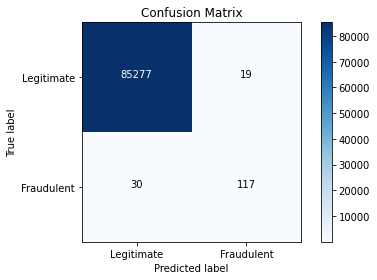

In [19]:
plot_confusion_matrix(matrix, classes = ['Legitimate', 'Fraudulent'])

##### Note that precision score most applicable for CC fraud, but we include F1 score as a common standard metric as well

In [20]:
print(f1_score(y_test, predicted_y.round()))

0.8268551236749118


In [21]:
print(precision_score(y_test, predicted_y.round()))

0.8602941176470589


### Approach 2: Deep Neural Net w/ SMOTE 

#### SMOTE = Synthetic Minority Oversampling Technique 